In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.utils import to_categorical

# 1. Load Data
filename = 'all_data (3).csv' # Corrected filename with a space
df = pd.read_csv(filename)

# 2. Separate Features and Target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# 3. Encode Target Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(np.unique(y_encoded))
print(f"Classes: {le.classes_}")

# 4. SPLIT DATA (70% Train, 30% Test)
# test_size=0.30 means 30% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

print(f"Training Data Shape: {X_train.shape} (70%)")
print(f"Testing Data Shape: {X_test.shape} (30%)")

# 5. Scale Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Reshape for Deep Learning (Samples, TimeSteps, Features)
X_train_dl = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_dl = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 7. One-hot encode targets for DL models
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

Classes: ['bruteForce' 'httpFlood' 'icmp-echo' 'normal' 'slowloris' 'slowpost'
 'tcp-syn' 'udp-flood']
Training Data Shape: (3498, 34) (70%)
Testing Data Shape: (1500, 34) (30%)


In [2]:
# ==============================
# FEATURE SELECTION (CFS-like)
# ==============================

# Convert scaled training data to DataFrame for correlation
X_train_df = pd.DataFrame(X_train_scaled)
y_train_series = pd.Series(y_train)

# Compute correlation of each feature with target
correlations = X_train_df.apply(lambda col: np.corrcoef(col, y_train_series)[0, 1])
correlations = correlations.abs()

# Select top-k important features
k = min(20, X_train_df.shape[1])  # select top 20 or all if fewer
top_features = correlations.sort_values(ascending=False).head(k).index.tolist()

print(f"Selected Top-{k} Features:", top_features)

# Reduce features
X_train_fs = X_train_scaled[:, top_features]
X_test_fs = X_test_scaled[:, top_features]

# Reshape again for DL
X_train_dl_fs = X_train_fs.reshape((X_train_fs.shape[0], 1, X_train_fs.shape[1]))
X_test_dl_fs = X_test_fs.reshape((X_test_fs.shape[0], 1, X_test_fs.shape[1]))


Selected Top-20 Features: [14, 24, 8, 19, 23, 10, 29, 9, 7, 28, 11, 30, 33, 32, 2, 5, 4, 18, 21, 16]


In [3]:
# ==============================
# LSTM FEATURE LEARNING
# ==============================

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, X_train_dl_fs.shape[2])))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(num_classes, activation='softmax'))

lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.summary()

history = lstm_model.fit(
    X_train_dl_fs, y_train_onehot,
    epochs=25,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,104 (94.16 KB)

 Trainable params: 24,104 (94.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2331 - loss: 2.0239 - val_accuracy: 0.2743 - val_loss: 1.8782
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2437 - loss: 1.8055 - val_accuracy: 0.3029 - val_loss: 1.5870
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3970 - loss: 1.5087 - val_accuracy: 0.6286 - val_loss: 1.2807
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6135 - loss: 1.2109 - val_accuracy: 0.6686 - val_loss: 1.0165
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6528 - loss: 0.9494 - val_accuracy: 0.6886 - val_loss: 0.8204
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7307 - loss: 0.7743 - val_accuracy: 0.7743 - val_loss: 0.6896
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8225 - loss: 0.6343 - val_accuracy: 0.8657 - val_loss: 0.5898
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8640 - loss: 0.5561 - val_accuracy: 0.8857 - val_l

In [4]:
# ==============================
# FEATURE EXTRACTION FROM LSTM
# ==============================

# Create a new Sequential model using the layers from the trained lstm_model,
# excluding the last (output) layer, to serve as the feature extractor.
feature_extractor = Sequential(lstm_model.layers[:-1])

X_train_lstm_feat = feature_extractor.predict(X_train_dl_fs)
X_test_lstm_feat = feature_extractor.predict(X_test_dl_fs)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(y_test, y_pred, class_names, title):
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ {title} Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, y_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    return acc



✅ KNN Accuracy: 97.93%
              precision    recall  f1-score   support

  bruteForce       0.96      0.90      0.93        60
   httpFlood       1.00      0.96      0.98       172
   icmp-echo       0.97      0.91      0.94       190
      normal       0.94      1.00      0.97       180
   slowloris       1.00      1.00      1.00       234
    slowpost       0.99      1.00      1.00       144
     tcp-syn       0.96      1.00      0.98       288
   udp-flood       1.00      1.00      1.00       232

    accuracy                           0.98      1500
   macro avg       0.98      0.97      0.97      1500
weighted avg       0.98      0.98      0.98      1500



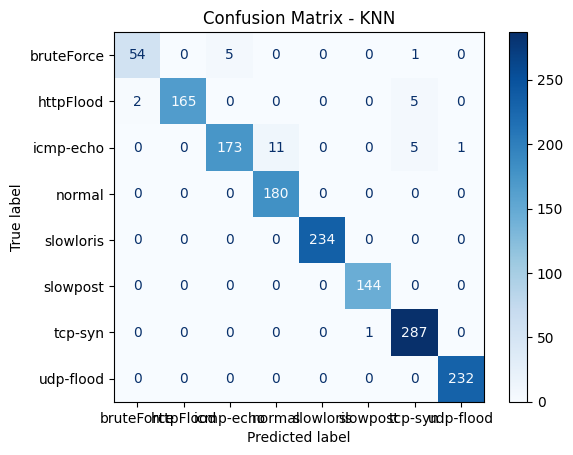

In [6]:
# Dictionary to store accuracies
accuracies = {}

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
accuracies['KNN'] = evaluate_model(y_test, y_pred_knn, le.classes_, "KNN")


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1647 - loss: 2.0177 - val_accuracy: 0.3857 - val_loss: 1.7936
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4769 - loss: 1.6546 - val_accuracy: 0.6771 - val_loss: 1.2552
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6798 - loss: 1.1219 - val_accuracy: 0.7629 - val_loss: 0.8317
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7762 - loss: 0.7386 - val_accuracy: 0.7771 - val_loss: 0.6238
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8546 - loss: 0.5484 - val_accuracy: 0.8400 - val_loss: 0.5218
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8716 - loss: 0.4765 - val_accuracy: 0.9286 - val_loss: 0.4220
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9227 - loss: 0.3837 - val_accuracy: 0.9029 - val_loss: 0.3733
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9203 - loss: 0.3361 - val_accuracy: 0.9200 - val_loss: 0.33

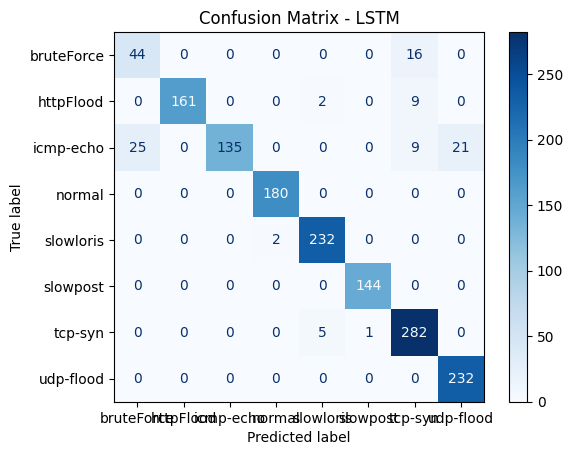

In [7]:
lstm = Sequential([
    LSTM(64, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm.fit(X_train_dl, y_train_onehot, epochs=10, batch_size=64,
              validation_split=0.1, verbose=1)

y_pred_lstm = np.argmax(lstm.predict(X_test_dl), axis=1)
accuracies['LSTM'] = evaluate_model(y_test, y_pred_lstm, le.classes_, "LSTM")


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.2301 - loss: 2.0172 - val_accuracy: 0.3543 - val_loss: 1.7926
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3480 - loss: 1.7020 - val_accuracy: 0.4686 - val_loss: 1.3386
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5406 - loss: 1.2500 - val_accuracy: 0.7400 - val_loss: 0.9618
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7226 - loss: 0.8883 - val_accuracy: 0.7686 - val_loss: 0.7336
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8005 - loss: 0.6852 - val_accuracy: 0.8114 - val_loss: 0.6106
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8304 - loss: 0.5558 - val_accuracy: 0.8171 - val_loss: 0.5025
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8453 - loss: 0.4689 - val_accuracy: 0.8829 - val_loss: 0.4289
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9081 - loss: 0.3858 - val_accuracy: 0.8543 - val_loss

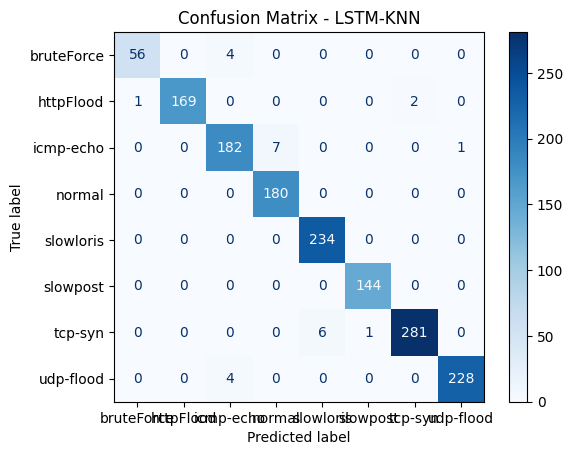

In [10]:
from tensorflow.keras.layers import Input

#  LSTM-KNN
# LSTM for feature extraction (Functional API)
inputs = Input(shape=(X_train_dl.shape[1], X_train_dl.shape[2]))
x = LSTM(64)(inputs)
x = Dense(32, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

lstm_knn_model = Model(inputs, outputs)
lstm_knn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
lstm_knn_model.fit(
    X_train_dl, y_train_onehot,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Feature extraction
feature_extractor = Model(inputs=lstm_knn_model.input, outputs=lstm_knn_model.layers[-2].output)
X_train_feat = feature_extractor.predict(X_train_dl)
X_test_feat = feature_extractor.predict(X_test_dl)

# KNN on features
knn2 = KNeighborsClassifier(n_neighbors=25)
knn2.fit(X_train_feat, y_train)
y_pred_lstm_knn = knn2.predict(X_test_feat)
accuracies['LSTM-KNN'] = evaluate_model(y_test, y_pred_lstm_knn, le.classes_, "LSTM-KNN")

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2472 - loss: 1.9124 - val_accuracy: 0.5257 - val_loss: 1.4922
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5543 - loss: 1.3993 - val_accuracy: 0.7429 - val_loss: 1.0481
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7223 - loss: 0.9788 - val_accuracy: 0.8086 - val_loss: 0.7731
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7826 - loss: 0.7093 - val_accuracy: 0.7914 - val_loss: 0.6217
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8136 - loss: 0.5871 - val_accuracy: 0.8000 - val_loss: 0.5300
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8606 - loss: 0.4887 - val_accuracy: 0.8800 - val_loss: 0.4655
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8832 - loss: 0.4401 - val_accuracy: 0.8800 - val_loss: 0.4137
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9013 - loss: 0.3770 - val_accuracy: 0.9371 - val_loss: 0.3749
Ep

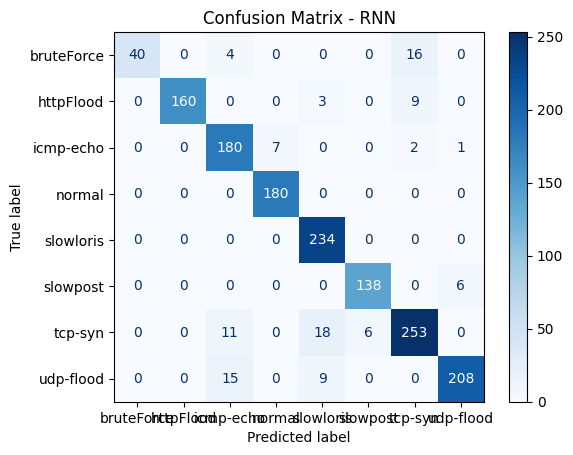

In [11]:
rnn = Sequential([
    SimpleRNN(64, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn.fit(X_train_dl, y_train_onehot, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
y_pred_rnn = np.argmax(rnn.predict(X_test_dl), axis=1)
accuracies['RNN'] = evaluate_model(y_test, y_pred_rnn, le.classes_, "RNN")


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2200 - loss: 1.9664 - val_accuracy: 0.5000 - val_loss: 1.6609
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5246 - loss: 1.5381 - val_accuracy: 0.6543 - val_loss: 1.1739
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6831 - loss: 1.0848 - val_accuracy: 0.7857 - val_loss: 0.8220
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7785 - loss: 0.7538 - val_accuracy: 0.8400 - val_loss: 0.6330
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8361 - loss: 0.5816 - val_accuracy: 0.8400 - val_loss: 0.5415
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8761 - loss: 0.4681 - val_accuracy: 0.8971 - val_loss: 0.4561
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9029 - loss: 0.4154 - val_accuracy: 0.8971 - val_loss: 0.3963
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9249 - loss: 0.3588 - val_accuracy: 0.9057 - val_loss: 0.3597
Ep

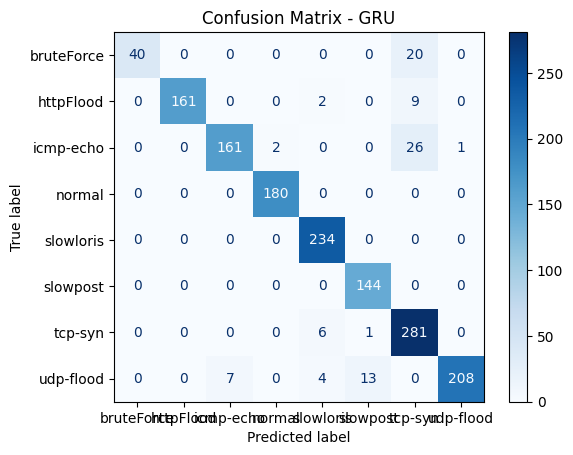

In [12]:
gru = Sequential([
    GRU(64, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru.fit(X_train_dl, y_train_onehot, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
y_pred_gru = np.argmax(gru.predict(X_test_dl), axis=1)
accuracies['GRU'] = evaluate_model(y_test, y_pred_gru, le.classes_, "GRU")


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2090 - loss: 1.9842 - val_accuracy: 0.5600 - val_loss: 1.6614
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5752 - loss: 1.5376 - val_accuracy: 0.7143 - val_loss: 1.1274
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7180 - loss: 1.0167 - val_accuracy: 0.7314 - val_loss: 0.7566
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7921 - loss: 0.6943 - val_accuracy: 0.7943 - val_loss: 0.5859
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8487 - loss: 0.5113 - val_accuracy: 0.8543 - val_loss: 0.4775
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8930 - loss: 0.4188 - val_accuracy: 0.8514 - val_loss: 0.4060
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9058 - loss: 0.3625 - val_accuracy: 0.9571 - val_loss: 0.3309
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9382 - loss: 0.3067 - val_accuracy: 0.9600 - val_loss: 0.2943
Ep

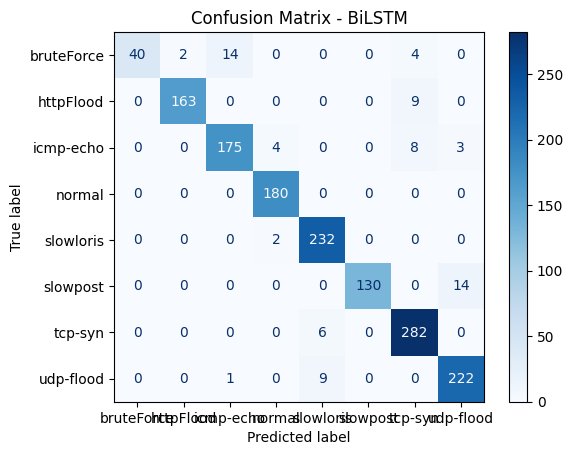

In [13]:
bilstm = Sequential([
    Bidirectional(LSTM(64), input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
bilstm.fit(X_train_dl, y_train_onehot, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
y_pred_bilstm = np.argmax(bilstm.predict(X_test_dl), axis=1)
accuracies['BiLSTM'] = evaluate_model(y_test, y_pred_bilstm, le.classes_, "BiLSTM")

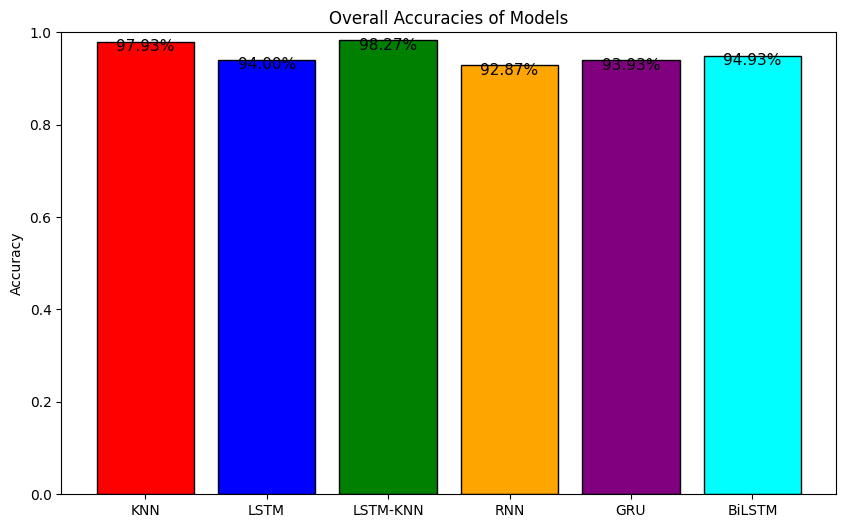

In [14]:
# Plot overall accuracies
# -------------------------
import matplotlib.pyplot as plt

models = list(accuracies.keys())
acc_values = list(accuracies.values())

plt.figure(figsize=(10,6))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
bars = plt.bar(models, acc_values, color=colors, edgecolor='black')

for bar, acc in zip(bars, acc_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.02,
             f'{acc*100:.2f}%', ha='center', color='black', fontsize=11)

plt.ylim(0, 1.0)
plt.ylabel('Accuracy')
plt.title('Overall Accuracies of Models')
plt.show()

In [15]:
from tensorflow.keras.models import Model

def hybrid_dl_knn(model, X_train_dl, X_test_dl, y_train, y_test, y_train_onehot, class_names, title):

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train_dl, y_train_onehot,
              epochs=10,
              batch_size=64,
              validation_split=0.1,
              verbose=1)

    feature_extractor = Model(inputs=model.input,
                              outputs=model.layers[-2].output)

    X_train_feat = feature_extractor.predict(X_train_dl)
    X_test_feat = feature_extractor.predict(X_test_dl)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_feat, y_train)
    y_pred = knn.predict(X_test_feat)

    acc = evaluate_model(y_test, y_pred, class_names, title)
    return acc


In [16]:
from tensorflow.keras.layers import Input

lstm_hybrid = Sequential([
    Input(shape=(X_train_dl.shape[1], X_train_dl.shape[2])),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])



In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate(y_test, y_pred, class_names, title):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n📊 {title} Evaluation:")
    print(f"Accuracy : {acc*100:.2f}%")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {title}")
    plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.2009 - loss: 2.0050 - val_accuracy: 0.4629 - val_loss: 1.7426
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5259 - loss: 1.6233 - val_accuracy: 0.6514 - val_loss: 1.2062
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6958 - loss: 1.0869 - val_accuracy: 0.7029 - val_loss: 0.8310
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7628 - loss: 0.7513 - val_accuracy: 0.8143 - val_loss: 0.6302
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8114 - loss: 0.5816 - val_accuracy: 0.8657 - val_loss: 0.5203
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8549 - loss: 0.4782 - val_accuracy: 0.8486 - val_loss: 0.4516
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8630 - loss: 0.4282 - val_accuracy: 0.8686 - val_loss: 0.4055
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9069 - loss: 0.3654 - val_accuracy: 0.8943 - val_los

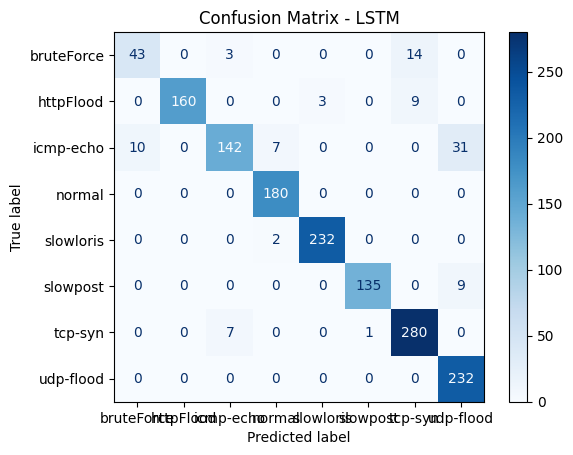

In [19]:
lstm = Sequential([
    LSTM(64, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm.fit(X_train_dl, y_train_onehot, epochs=10, batch_size=64,
         validation_split=0.1, verbose=1)

y_pred_lstm = np.argmax(lstm.predict(X_test_dl), axis=1)
accuracies['LSTM']= evaluate(y_test, y_pred_lstm, le.classes_, "LSTM")


In [20]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# -----------------------
# LSTM-KNN Model
# -----------------------
inputs = Input(shape=(X_train_dl.shape[1], X_train_dl.shape[2]))
x = LSTM(64)(inputs)
x = Dense(32, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

lstm_knn = Model(inputs=inputs, outputs=outputs)

lstm_knn.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

lstm_knn.fit(X_train_dl, y_train_onehot,
             epochs=10, batch_size=64,
             validation_split=0.1, verbose=1)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2750 - loss: 2.0156 - val_accuracy: 0.5114 - val_loss: 1.7687
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4848 - loss: 1.6509 - val_accuracy: 0.6057 - val_loss: 1.2584
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6359 - loss: 1.1557 - val_accuracy: 0.7286 - val_loss: 0.8467
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7214 - loss: 0.7771 - val_accuracy: 0.7857 - val_loss: 0.6338
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8129 - loss: 0.5973 - val_accuracy: 0.8286 - val_loss: 0.5276
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8495 - loss: 0.4863 - val_accuracy: 0.8686 - val_loss: 0.4644
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8874 - loss: 0.4222 - val_accuracy: 0.9000 - val_loss: 0.4043
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9175 - loss: 0.3719 - val_accuracy: 0.9286 - val_los

In [21]:
# Feature extractor from Dense(32)
feature_extractor = Model(
    inputs=lstm_knn.input,
    outputs=lstm_knn.layers[-2].output
)

X_train_feat = feature_extractor.predict(X_train_dl)
X_test_feat = feature_extractor.predict(X_test_dl)


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



📊 LSTM-KNN Evaluation:
Accuracy : 98.87%
Precision: 0.9889
Recall   : 0.9887
F1-score : 0.9886


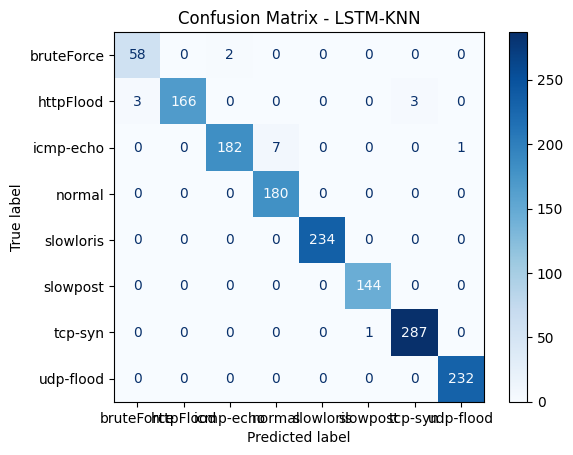

In [22]:
knn2 = KNeighborsClassifier(n_neighbors=25)
knn2.fit(X_train_feat, y_train)

y_pred_lstm_knn = knn2.predict(X_test_feat)
accuracies['LSTM-KNN']= evaluate(y_test, y_pred_lstm_knn, le.classes_, "LSTM-KNN")


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2150 - loss: 1.9117 - val_accuracy: 0.4429 - val_loss: 1.5031
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5129 - loss: 1.3984 - val_accuracy: 0.5514 - val_loss: 1.1343
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5995 - loss: 1.0652 - val_accuracy: 0.7000 - val_loss: 0.8875
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7293 - loss: 0.8203 - val_accuracy: 0.8029 - val_loss: 0.7253
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7580 - loss: 0.6884 - val_accuracy: 0.7971 - val_loss: 0.6257
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7975 - loss: 0.5805 - val_accuracy: 0.8371 - val_loss: 0.5498
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8224 - loss: 0.5167 - val_accuracy: 0.8143 - val_loss: 0.5002
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8323 - loss: 0.4586 - val_accuracy: 0.8486 - val_loss: 0.4552
Ep

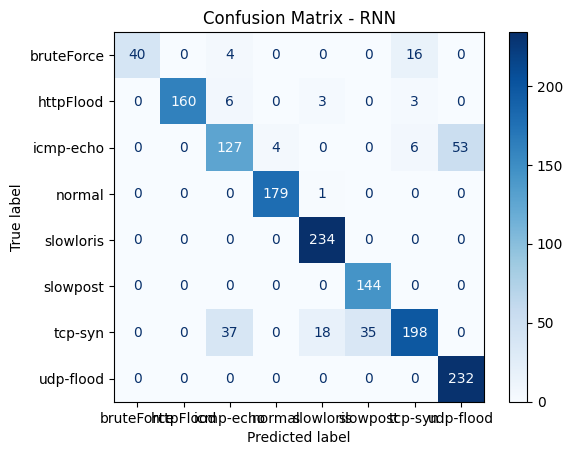

In [23]:
rnn = Sequential([
    SimpleRNN(64, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

rnn.fit(X_train_dl, y_train_onehot, epochs=10, batch_size=64,
        validation_split=0.1, verbose=1)

y_pred_rnn = np.argmax(rnn.predict(X_test_dl), axis=1)
accuracies['RNN']= evaluate(y_test, y_pred_rnn, le.classes_, "RNN")


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3001 - loss: 1.9860 - val_accuracy: 0.4857 - val_loss: 1.6972
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5112 - loss: 1.5560 - val_accuracy: 0.6286 - val_loss: 1.1940
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6206 - loss: 1.0940 - val_accuracy: 0.6314 - val_loss: 0.8366
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7392 - loss: 0.7622 - val_accuracy: 0.8429 - val_loss: 0.6628
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8379 - loss: 0.6053 - val_accuracy: 0.8229 - val_loss: 0.5507
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8550 - loss: 0.5092 - val_accuracy: 0.9029 - val_loss: 0.4657
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9150 - loss: 0.4187 - val_accuracy: 0.8771 - val_loss: 0.4255
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9283 - loss: 0.3710 - val_accuracy: 0.9000 - val_loss: 0.3796
E

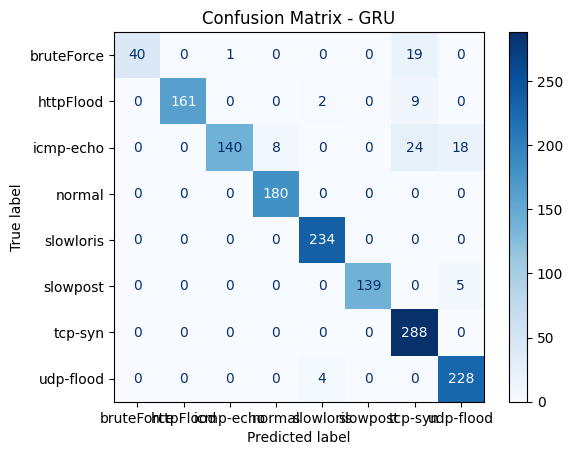

In [24]:
gru = Sequential([
    GRU(64, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

gru.fit(X_train_dl, y_train_onehot, epochs=10, batch_size=64,
        validation_split=0.1, verbose=1)

y_pred_gru = np.argmax(gru.predict(X_test_dl), axis=1)
accuracies['GRU']= evaluate(y_test, y_pred_gru, le.classes_, "GRU")


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.2442 - loss: 1.9849 - val_accuracy: 0.4600 - val_loss: 1.6670
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4898 - loss: 1.5047 - val_accuracy: 0.5714 - val_loss: 1.1065
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6657 - loss: 0.9906 - val_accuracy: 0.6714 - val_loss: 0.7856
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7962 - loss: 0.6906 - val_accuracy: 0.8514 - val_loss: 0.5823
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8534 - loss: 0.5290 - val_accuracy: 0.8457 - val_loss: 0.5335
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8762 - loss: 0.4593 - val_accuracy: 0.8457 - val_loss: 0.4692
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8943 - loss: 0.3829 - val_accuracy: 0.9057 - val_loss: 0.3798
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9187 - loss: 0.3408 - val_accuracy: 0.9514 - val_loss: 0.3297
E

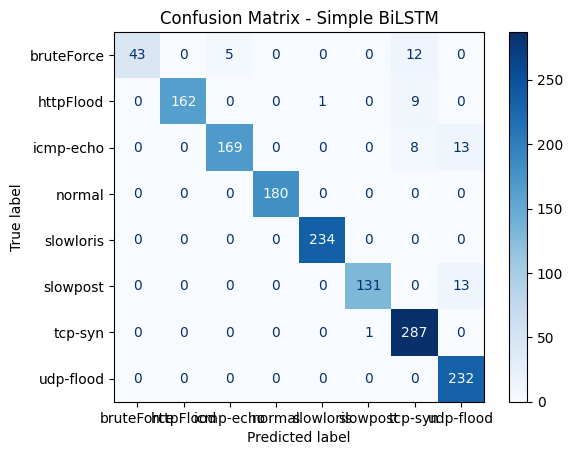

In [25]:
bilstm = Sequential([
    Bidirectional(LSTM(64), input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

bilstm.fit(X_train_dl, y_train_onehot, epochs=10, batch_size=64,
           validation_split=0.1, verbose=1)

y_pred_bilstm = np.argmax(bilstm.predict(X_test_dl), axis=1)
accuracies['BiLSTM']= evaluate(y_test, y_pred_bilstm, le.classes_, "Simple BiLSTM")


In [26]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_test, y_pred, title):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n📊 {title} Evaluation:")
    print(f"Accuracy : {acc*100:.2f}%")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    return acc, prec, rec, f1


In [27]:
results = []

# KNN
acc, prec, rec, f1 = evaluate_model(y_test, y_pred_knn, "KNN")
results.append(["KNN", acc, prec, rec, f1])

# LSTM
acc, prec, rec, f1 = evaluate_model(y_test, y_pred_lstm, "LSTM")
results.append(["LSTM", acc, prec, rec, f1])

# LSTM-KNN
acc, prec, rec, f1 = evaluate_model(y_test, y_pred_lstm_knn, "LSTM-KNN")
results.append(["LSTM-KNN", acc, prec, rec, f1])

# RNN
acc, prec, rec, f1 = evaluate_model(y_test, y_pred_rnn, "RNN")
results.append(["RNN", acc, prec, rec, f1])

# GRU
acc, prec, rec, f1 = evaluate_model(y_test, y_pred_gru, "GRU")
results.append(["GRU", acc, prec, rec, f1])

# BiLSTM
acc, prec, rec, f1 = evaluate_model(y_test, y_pred_bilstm, "BiLSTM")
results.append(["BiLSTM", acc, prec, rec, f1])



📊 KNN Evaluation:
Accuracy : 97.93%
Precision: 0.9797
Recall   : 0.9793
F1-score : 0.9791

📊 LSTM Evaluation:
Accuracy : 93.60%
Precision: 0.9384
Recall   : 0.9360
F1-score : 0.9345

📊 LSTM-KNN Evaluation:
Accuracy : 98.87%
Precision: 0.9889
Recall   : 0.9887
F1-score : 0.9886

📊 RNN Evaluation:
Accuracy : 87.60%
Precision: 0.8807
Recall   : 0.8760
F1-score : 0.8715

📊 GRU Evaluation:
Accuracy : 94.00%
Precision: 0.9466
Recall   : 0.9400
F1-score : 0.9379

📊 BiLSTM Evaluation:
Accuracy : 95.87%
Precision: 0.9618
Recall   : 0.9587
F1-score : 0.9580


In [28]:
df_results = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1-score"
])

# Convert accuracy to percentage for readability
df_results["Accuracy"] = df_results["Accuracy"] * 100

df_results


,Model,Accuracy,Precision,Recall,F1-score
0,KNN,97.933333,0.979689,0.979333,0.979133
1,LSTM,93.600000,0.938388,0.936000,0.934452
2,LSTM-KNN,98.866667,0.988852,0.988667,0.988642
3,RNN,87.600000,0.880698,0.876000,0.871453
4,GRU,94.000000,0.946558,0.940000,0.937872
5,BiLSTM,95.866667,0.961762,0.958667,0.957972


Loading all_data (3).csv...
Training LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Hybrid KNN...


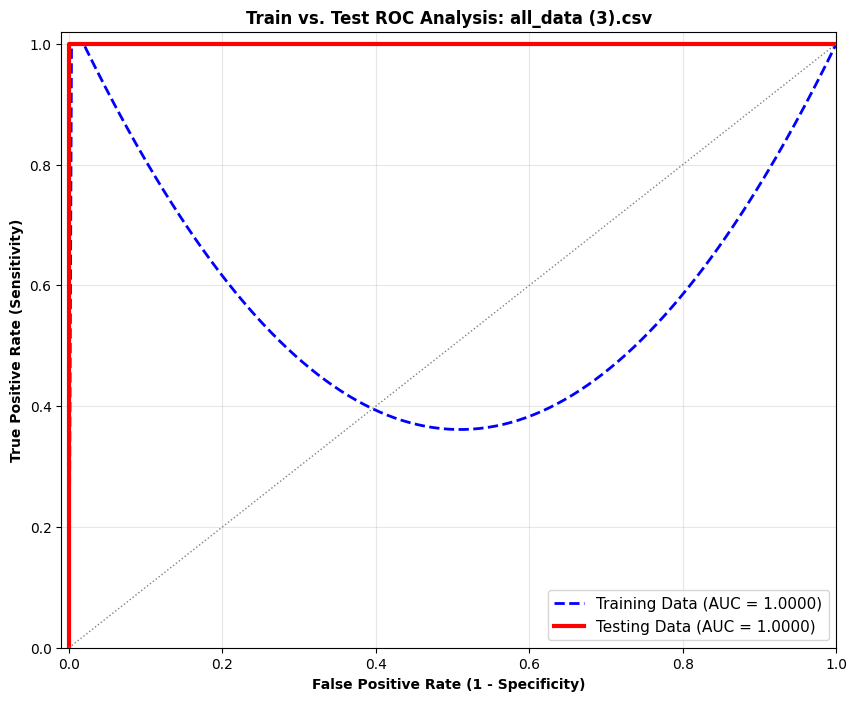

Plot Generated Successfully.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from scipy.interpolate import make_interp_spline

# ==========================================
# 1. LOAD DATA
# ==========================================
filename = 'all_data (3).csv'
print(f"Loading {filename}...")
df = pd.read_csv(filename)

# Separate Features (X) and Target (y)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode Target Labels (e.g., 'normal' -> 3)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(np.unique(y_encoded))

# ==========================================
# 2. SPLIT & PREPROCESS
# ==========================================
# 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

# Scale Data (Fit on Train, Transform Test)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM [samples, time_steps=1, features]
X_train_dl = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_dl = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# One-hot encode for LSTM training
y_train_onehot = to_categorical(y_train, num_classes)

# ==========================================
# 3. TRAIN MODELS
# ==========================================

# --- A. Train LSTM (Feature Extractor) ---
print("Training LSTM...")
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(1, X_train_scaled.shape[1]), activation='relu'))
lstm.add(Dense(num_classes, activation='softmax'))
lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train for 10 Epochs
lstm.fit(X_train_dl, y_train_onehot, epochs=10, batch_size=32, verbose=0)

# --- B. Extract Deep Features ---
# Use the trained LSTM layer to transform data
extractor = Model(inputs=lstm.inputs, outputs=lstm.layers[0].output)
train_features = extractor.predict(X_train_dl, verbose=0)
test_features = extractor.predict(X_test_dl, verbose=0)

# --- C. Train Hybrid KNN (K=25) ---
print("Training Hybrid KNN...")
hybrid = KNeighborsClassifier(n_neighbors=25)
hybrid.fit(train_features, y_train)

# ==========================================
# 4. CALCULATE ROC (TRAIN vs TEST)
# ==========================================
# We need to define "Normal" vs "Attack" for the ROC curve
normal_class = 'normal'
if normal_class in le.classes_:
    normal_idx = np.where(le.classes_ == normal_class)[0][0]
else:
    normal_idx = 0
    print("Warning: 'normal' class not found, using index 0.")

# Create Binary Targets (0=Normal, 1=Attack)
y_train_bin = (y_train != normal_idx).astype(int)
y_test_bin = (y_test != normal_idx).astype(int)

# Get Probabilities of Attack (1 - Prob Normal)
# We calculate this for BOTH Train (to check learning) and Test (to check performance)
train_probs = 1 - hybrid.predict_proba(train_features)[:, normal_idx]
test_probs = 1 - hybrid.predict_proba(test_features)[:, normal_idx]

# Calculate Curves
fpr_train, tpr_train, _ = roc_curve(y_train_bin, train_probs)
auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test_bin, test_probs)
auc_test = auc(fpr_test, tpr_test)

# Smoothing Helper Function
def get_smooth_curve(fpr, tpr):
    fpr_u, ind = np.unique(fpr, return_index=True)
    tpr_u = tpr[ind]
    if len(fpr_u) < 4: return fpr, tpr
    x_new = np.linspace(fpr_u.min(), fpr_u.max(), 300)
    try:
        spl = make_interp_spline(fpr_u, tpr_u, k=2)
        y_smooth = np.clip(spl(x_new), 0, 1)
        return x_new, y_smooth
    except:
        return fpr, tpr

ft_s, tt_s = get_smooth_curve(fpr_train, tpr_train)
fe_s, te_s = get_smooth_curve(fpr_test, tpr_test)

# ==========================================
# 5. PLOT CHART
# ==========================================
plt.figure(figsize=(10, 8))

# Plot Training Curve (Blue Dashed)
plt.plot(ft_s, tt_s, color='blue', linestyle='--', lw=2,
         label=f'Training Data (AUC = {auc_train:.4f})')

# Plot Testing Curve (Red Solid)
plt.plot(fe_s, te_s, color='red', linestyle='-', lw=3,
         label=f'Testing Data (AUC = {auc_test:.4f})')

# Diagonal Line
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', lw=1)

# Formatting
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate (1 - Specificity)', fontweight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontweight='bold')
plt.title(f'Train vs. Test ROC Analysis: {filename}', fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)

plt.show()
print("Plot Generated Successfully.")

In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd


In [36]:
def eval_binary(y_true, y_pred, normal_idx):
    y_true_bin = (y_true != normal_idx).astype(int)   # 1 = Attack
    y_pred_bin = (y_pred != normal_idx).astype(int)

    return {
        "Accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "Precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
        "Recall": recall_score(y_true_bin, y_pred_bin, zero_division=0),
        "F1": f1_score(y_true_bin, y_pred_bin, zero_division=0)
    }


In [37]:
normal_class = 'normal'
if normal_class in le.classes_:
    normal_idx = list(le.classes_).index(normal_class)
else:
    normal_idx = 0
    print("'normal' class not found, using index 0 as Benign.")


In [38]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", pd.Series(y_train).value_counts())
print("After SMOTE:\n", pd.Series(y_train_smote).value_counts())


Before SMOTE: 6    672
4    546
7    541
2    442
3    420
1    401
5    336
0    140
Name: count, dtype: int64
After SMOTE:
 3    672
6    672
7    672
2    672
4    672
5    672
1    672
0    672
Name: count, dtype: int64


In [39]:
results = []

# ---- Without SMOTE ----
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

res_knn_no = eval_binary(y_test, y_pred_knn, normal_idx)
res_knn_no["Model"] = "KNN"
res_knn_no["SMOTE"] = "No"
results.append(res_knn_no)

# ---- With SMOTE ----
knn_sm = KNeighborsClassifier(n_neighbors=25)
knn_sm.fit(X_train_smote, y_train_smote)
y_pred_knn_sm = knn_sm.predict(X_test_scaled)

res_knn_yes = eval_binary(y_test, y_pred_knn_sm, normal_idx)
res_knn_yes["Model"] = "KNN"
res_knn_yes["SMOTE"] = "Yes"
results.append(res_knn_yes)


In [41]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

num_classes = len(le.classes_)

y_train_onehot = to_categorical(y_train, num_classes)

lstm = Sequential([
    LSTM(64, input_shape=(1, X_train_scaled.shape[1]), activation='relu'),
    Dense(num_classes, activation='softmax')
])

lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm.fit(X_train_dl, y_train_onehot, epochs=10, batch_size=32, verbose=0)

extractor = Model(inputs=lstm.inputs, outputs=lstm.layers[0].output)

train_feat = extractor.predict(X_train_dl, verbose=0)
test_feat = extractor.predict(X_test_dl, verbose=0)


In [42]:
# Without SMOTE
hybrid = KNeighborsClassifier(n_neighbors=25)
hybrid.fit(train_feat, y_train)
y_pred_hybrid = hybrid.predict(test_feat)

res_h_no = eval_binary(y_test, y_pred_hybrid, normal_idx)
res_h_no["Model"] = "LSTM-KNN"
res_h_no["SMOTE"] = "No"
results.append(res_h_no)
# With SMOTE
train_feat_sm, y_train_feat_sm = smote.fit_resample(train_feat, y_train)

hybrid_sm = KNeighborsClassifier(n_neighbors=25)
hybrid_sm.fit(train_feat_sm, y_train_feat_sm)
y_pred_hybrid_sm = hybrid_sm.predict(test_feat)

res_h_yes = eval_binary(y_test, y_pred_hybrid_sm, normal_idx)
res_h_yes["Model"] = "LSTM-KNN"
res_h_yes["SMOTE"] = "Yes"
results.append(res_h_yes)



In [43]:
df_results = pd.DataFrame(results)
df_results = df_results[["Model", "SMOTE", "Accuracy", "Precision", "Recall", "F1"]]
print("\n📊 Performance Comparison (Attack vs Benign):\n")
display(df_results)



📊 Performance Comparison (Attack vs Benign):



,Model,SMOTE,Accuracy,Precision,Recall,F1
0,KNN,No,0.992667,1.0,0.991667,0.995816
1,KNN,Yes,0.994000,1.0,0.993182,0.996579
2,LSTM-KNN,No,0.994667,1.0,0.993939,0.996960
3,LSTM-KNN,Yes,0.994667,1.0,0.993939,0.996960


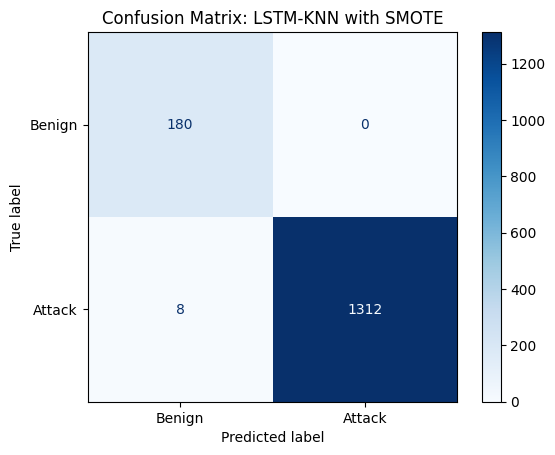

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(
    (y_test != normal_idx).astype(int),
    (y_pred_hybrid_sm != normal_idx).astype(int)
)

disp = ConfusionMatrixDisplay(cm, display_labels=["Benign", "Attack"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: LSTM-KNN with SMOTE")
plt.show()
